# Downsampling data to perform aggregate predictions
TODO: 
- Update data exploration! Regarder la distribution par heure/mois/etc. ou autre time step. 
- Set up is_legal feature
- Changer fonction split_norm_data pour qu'elle return aussi (train_mean, train_std) pour pouvoir faire le mapping valeurs normalisées -> pas normalisées
- Continuer à declutter le notebook avec le script.py pour rendre l'exploration plus visible

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from script import *
%load_ext autoreload
%autoreload 2

### Load data

In [3]:
DATA_PATH = '../data/405.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format="%Y-%m-%d %H:%M:%S.%f")
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


In [4]:
feature_cols = [col for col in data.columns if col != 'crossTime']
features = data[feature_cols]
features.index = data.crossTime

# Downsample and add vehicle counts
resampled = features.resample('1h')
features = resampled.sum()
features['n_vehicles'] = resampled.size()

### Feature engineering

#### HGV movement restrictions

Heavy goods vehicle are restricted from travelling on sundays, and from 10PM to 5AM all other days.
We add a `is_legal` indicator feature to reflect this

In [5]:
legal_driving_start = 5
legal_driving_end = 22
legal_driving_duration = legal_driving_end - legal_driving_start
sunday = 6

dayofweek = pd.Series(features.index.dayofweek, index=features.index)
hours = pd.Series(features.index.hour, index=features.index)
shifted_hours = hours - legal_driving_start

features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
features.head(10)

,speed,weight,n_vehicles,is_legal
crossTime,,,,
2011-04-01 00:00:00,306,38090,3,0
2011-04-01 01:00:00,540,107870,6,0
2011-04-01 02:00:00,258,69670,3,0
2011-04-01 03:00:00,350,43060,4,0
2011-04-01 04:00:00,1211,290270,14,0
2011-04-01 05:00:00,3398,825050,39,1
2011-04-01 06:00:00,7120,1310680,81,1
2011-04-01 07:00:00,12966,2287160,146,1
2011-04-01 08:00:00,13541,2729830,156,1


#### Time periodicity features
Datetime column `crossTime` not useful in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity. In order to deal with periodicity, we use sine and cosine transforms to get usable signals.

In [6]:
# Transform to seconds
timestamp_s = features.index.map(pd.Timestamp.timestamp)

# Corresponding length in seconds for day, week, year
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

In [7]:
# Add sin/cos periodicity columns to features dataframe
def add_time_period_cols(time_length, time_string):
    features[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
    features[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))
    
add_time_period_cols(day_s, 'day')
add_time_period_cols(week_s, 'week')
add_time_period_cols(year_s, 'year')

In [8]:
features.head(2)

,speed,weight,n_vehicles,is_legal,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,,
2011-04-01 00:00:00,306,38090,3,0,1.461574e-12,1.000000,0.781831,0.62349,0.999768,0.021556
2011-04-01 01:00:00,540,107870,6,0,2.588190e-01,0.965926,0.804598,0.59382,0.999783,0.020839


Text(0.5, 1.0, 'Year period signals')

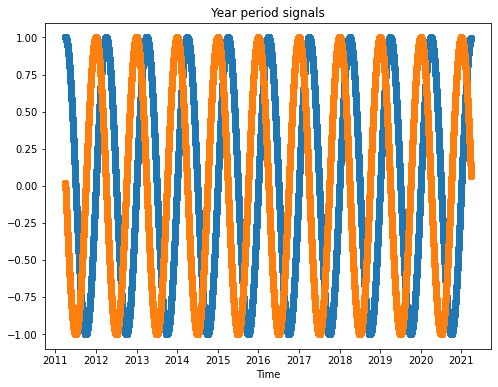

In [9]:
plt.scatter(y=np.array(features['year_sin']), x=features.index)
plt.scatter(y=np.array(features['year_cos']), x=features.index)
plt.xlabel('Time')
plt.title('Year period signals')

### Split and normalize data

In [10]:
train, val, test, train_mean, train_std = split_norm_data(features, return_mean_std=True)

### Predicting single feature (weight)


In [18]:
# Create a daily window: use last 24 hours to predict next hour
day_window = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=['n_vehicles'],
                            train_df=train, val_df=val, test_df=test)
day_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['n_vehicles']

In [19]:
# General use window: use last week to predict next day
week_window = WindowGenerator(input_width=24*7, label_width=24, shift=24, label_columns=['n_vehicles'],
                               train_df=train, val_df=val, test_df=test)
week_window

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['n_vehicles']

#### Plot windows

In [13]:
def example_data(window):
    return tf.stack([np.array(train[:window.total_window_size]),
                     np.array(train[10000:10000+window.total_window_size]),
                     np.array(train[50000:50000+window.total_window_size])])

2021-12-12 17:28:55.742098: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-12 17:28:55.742503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-12 17:28:55.742940: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


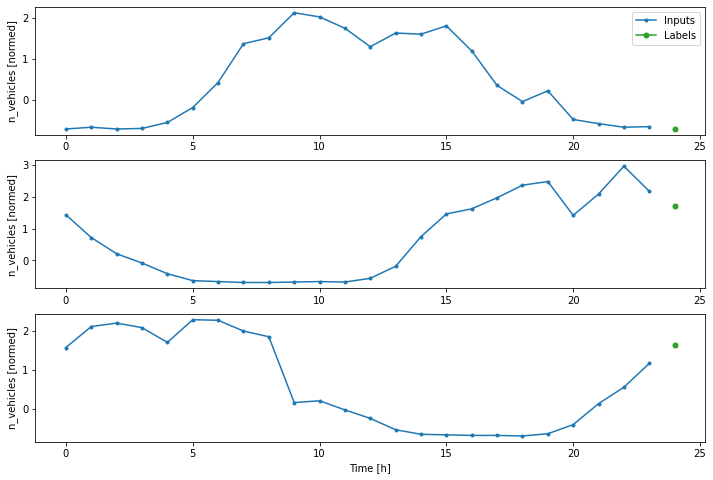

In [14]:
ex_data = example_data(day_window)
ex_inputs, ex_labels = day_window.split_window(ex_data)

day_window.set_example(ex_inputs, ex_labels)
day_window.plot()

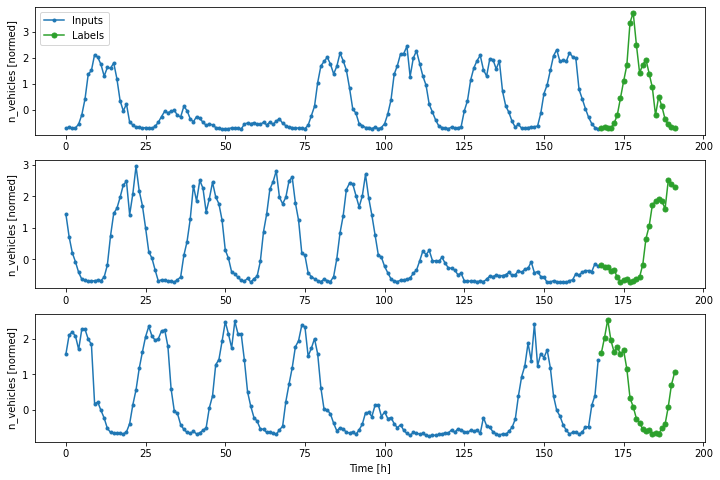

In [15]:
ex_data = example_data(week_window)
ex_inputs, ex_labels = week_window.split_window(ex_data)

week_window.set_example(ex_inputs, ex_labels)
week_window.plot()

#### Baseline

In [26]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

single_step_window = single_step_window(train, val, test)

In [27]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Input indices: [0]
Label indices: [1]
Label column name(s): ['n_vehicles']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0]
Label indices: [1]
Label column name(s): ['n_vehicles']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Ind

2021-12-12 17:35:26.081470: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-12 17:35:26.102171: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


548/548 [==============================] - 1s 1ms/step - loss: 0.1284 - mean_absolute_error: 0.2233


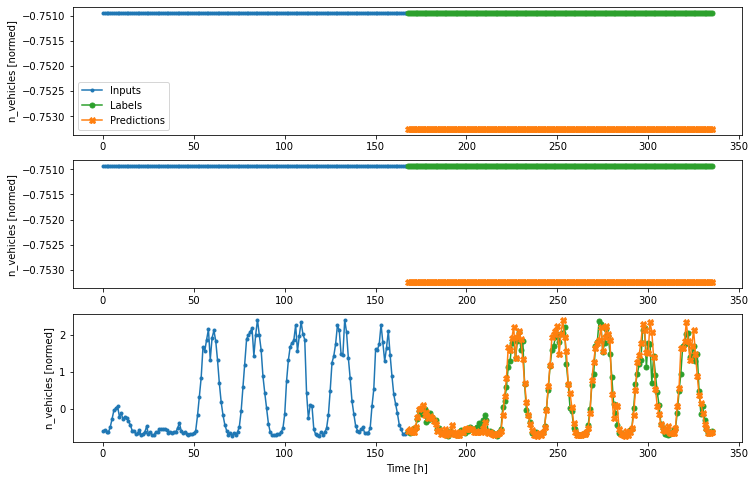

In [30]:
wide_window = make_window(train, val, test, input_w=7*24, label_w=7*24, shift=7*24)

wide_window.plot(baseline)

#### Linear

In [19]:
linear = linear_model()

In [20]:
history = compile_and_fit(linear, single_step_window)
IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

548/548 [==============================] - 2s 3ms/step - loss: 0.1247 - mean_absolute_error: 0.2364


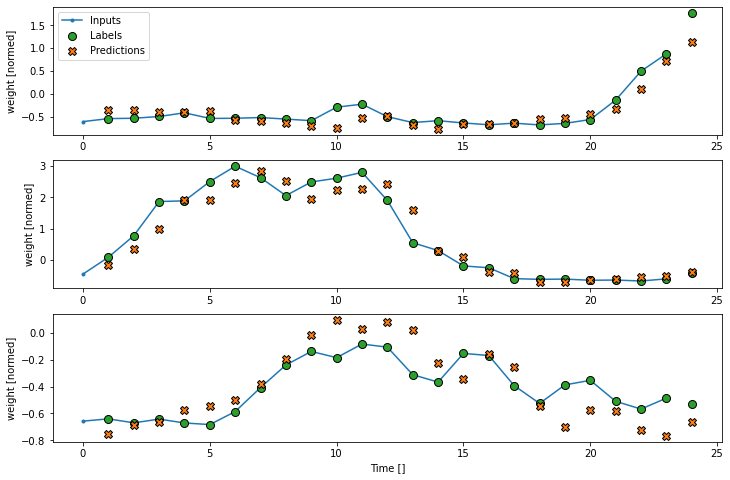

In [21]:
wide_window.plot(linear)

#### Dense

In [22]:
dense = dense_model()

history = compile_and_fit(dense, single_step_window)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

548/548 [==============================] - 2s 3ms/step - loss: 0.0683 - mean_absolute_error: 0.1494A: 0s - loss: 0.0709 - mean_ab


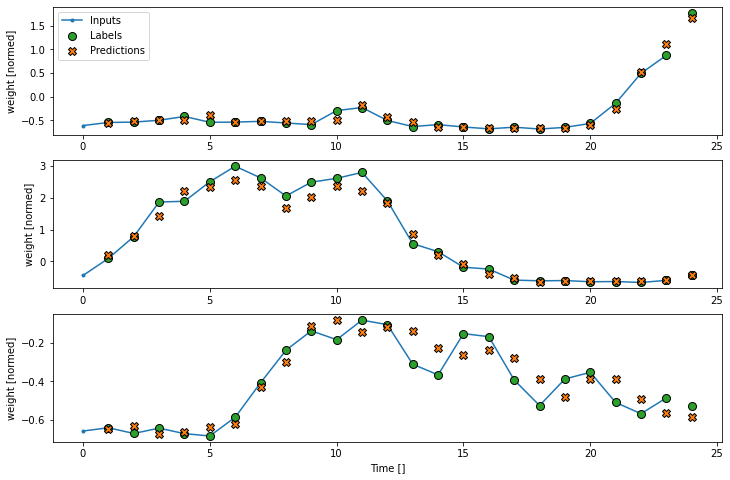

In [23]:
wide_window.plot(dense)

#### Multi-step dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

In [24]:
day_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['weight']

In [25]:
multi_step_dense = multi_step_dense_model()

history = compile_and_fit(multi_step_dense, day_window)
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(day_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(day_window.test, verbose=0)

547/547 [==============================] - 2s 3ms/step - loss: 0.0489 - mean_absolute_error: 0.1256


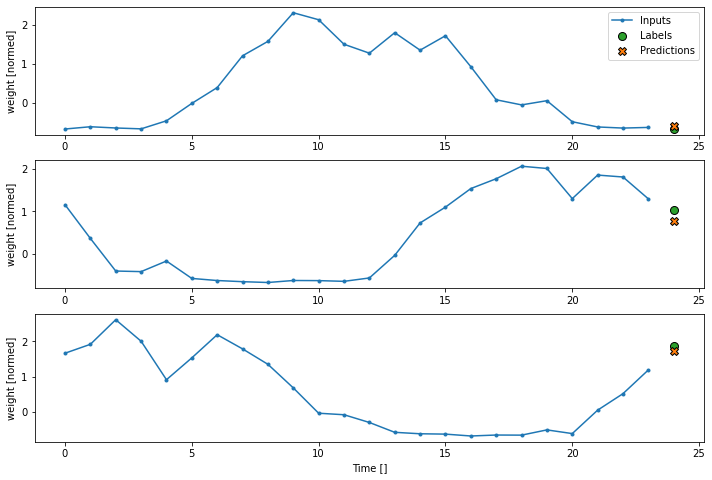

In [26]:
day_window.plot(multi_step_dense)

#### Convolutional NN

In [27]:
conv_model = conv_model(24)

history = compile_and_fit(conv_model, day_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(day_window.val)
performance['Conv'] = conv_model.evaluate(day_window.test, verbose=0)

547/547 [==============================] - 2s 3ms/step - loss: 0.0524 - mean_absolute_error: 0.1317A: 0s - loss: 0.0487 - mean_absol


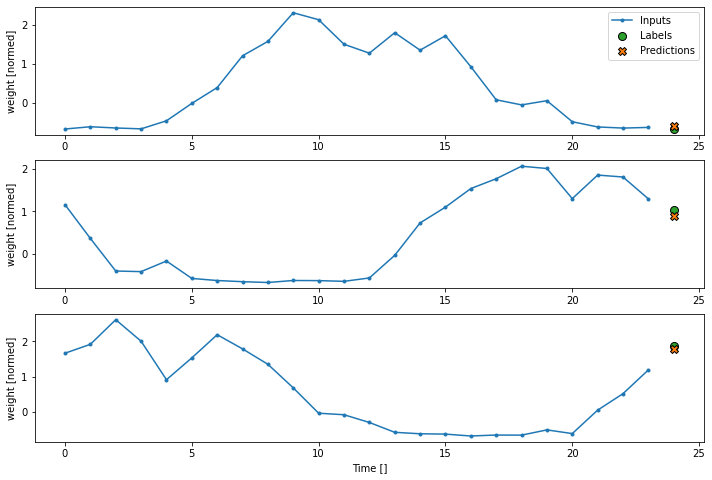

In [28]:
day_window.plot(conv_model)

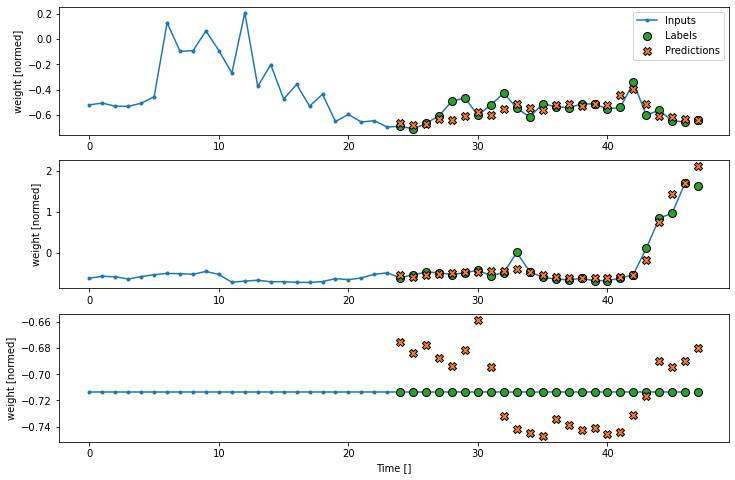

In [29]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (24 - 1)
wide_conv_window = conv_window(train, val, test, INPUT_WIDTH, LABEL_WIDTH)
wide_conv_window.plot(conv_model)

#### Recurrent NN
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [30]:
rnn = lstm_model()

history = compile_and_fit(rnn, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = rnn.evaluate(wide_window.val)
performance['LSTM'] = rnn.evaluate(wide_window.test, verbose=0)

547/547 [==============================] - 4s 6ms/step - loss: 0.0551 - mean_absolute_error: 0.1326A: 1s - loss: 0.0546 - mean_


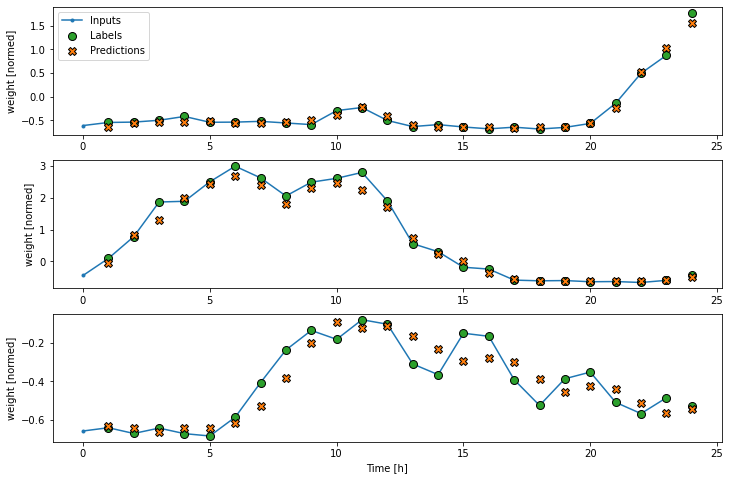

In [33]:
wide_window.plot(rnn)

#### Performance

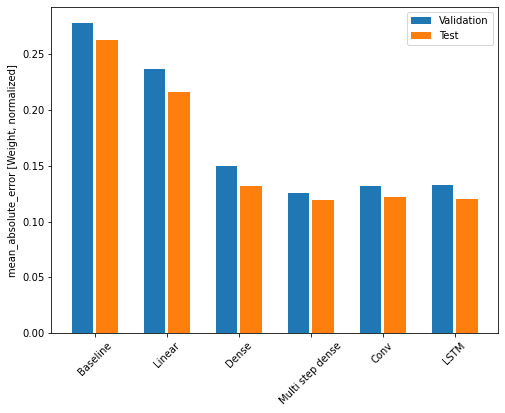

In [38]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Weight, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [37]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2626
Linear      : 0.2164
Dense       : 0.1319
Multi step dense: 0.1190
Conv        : 0.1221
LSTM        : 0.1200


Seems like Multi-step dense model and recurrent neural network are best.

### Predicting all features (multi-output model)

#### Redefine windows
Include all wanted columns in the `label_cols` argument

#### Baseline

#### Dense

#### RNN

#### Advanced: Residual connections
On avait skip ça dans le tutoriel car ça n'aurait pas bien marché avec le non-downsampled data mais pourrait mieux marcher si notre downsampling est sur une intervalle assez petite si j'ai bien compris.

### Multi-step models
- See Forecasting.ipynb

Est-ce qu'on reste sur des single-step ou on utilise multi-step pour faire la prédiction?